In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cmo
import xarray as xr
import os
from glob import glob

mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['font.size'] = 18

In [2]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(project='UWAS0064')
cluster.scale(12)

from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://10.12.205.21:42171 Dashboard: http://10.12.205.21:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
mdict = dict()

mdict = {'ACCESS-ESM1-5': {'inst': 'CSIRO-ARCCSS',
                           'var': 'sivol',
                           'source': 'scratch',
                           'latname': 'latitude'},
         'CanESM5': {'inst': 'CCCma',
                     'var': 'simass',
                     'source': 'scratch',
                     'latname': 'latitude'},
         'CESM2': {'inst': 'NCAR',
                   'var': 'sivol',
                   'source': 'cheyenne',
                   'latname': 'lat'},
         'CNRM-CM6-1': {'inst': 'CNRM-CERFACS',
                        'var': 'sivol',
                        'source': 'scratch',
                        'latname': 'lat'},
         'EC-Earth3': {'inst': 'EC-Earth-Consortium',
                       'var': 'sivol',
                       'source': 'scratch',
                       'latname': 'latitude'},
         'GISS-E2-1-G': {'inst': 'NASA-GISS',
                         'var': 'sivol',
                         'source': 'scratch',
                         'latname': 'lat'},
         'GISS-E2-1-H': {'inst': 'NASA-GISS',
                         'var': 'sivol',
                         'source': 'scratch',
                         'latname': 'lat'},
         'IPSL-CM6A-LR': {'inst': 'IPSL',
                          'var': 'sivol',
                          'source': 'cheyenne',
                          'latname': 'nav_lat'},
         'MIROC6': {'inst': 'MIROC',
                    'var': 'simass',
                    'source': 'scratch',
                    'latname': 'latitude'},
         'MPI-ESM1-2-LR': {'inst': 'MPI-M',
                           'var': 'sivol',
                           'source': 'scratch',
                           'latname': 'latitude'},
         'MPI-ESM1-2-HR': {'inst': 'MPI-M',
                           'var': 'sivol',
                           'source': 'scratch',
                           'latname': 'latitude'},
         'UKESM1-0-LL': {'inst': 'MOHC',
                         'var': 'sivol',
                         'source': 'scratch',
                         'latname': 'latitude'}
         }

In [15]:
def getseaicevol(model, mdict):
    inst = mdict[model]['inst']
    var = mdict[model]['var']
    source = mdict[model]['source']
    
    if source == 'cheyenne':
        droot = '/glade/collections/cmip/CMIP6/CMIP/'+inst+'/'+model+'/historical/'
        ddirs = sorted(glob(droot + 'r*'))
        
        for n, ddir in enumerate(ddirs[:5]):
            print(ddir)
            if source == 'cheyenne':
                if model == 'CESM2':
                    dfiles = sorted(glob(ddir + '/SImon/'+var+'/gn/v**/*.nc', recursive=True))
                else:
                    dfiles = sorted(glob(ddir + '/SImon/'+var+'/gn/v**/'+var+'/*.nc', recursive=True))
            
            if dfiles != []:
                if n == 0 or 'mfds0' not in vars():
                    mfds0 = xr.open_mfdataset(dfiles, combine='by_coords', parallel=True)
                else:
                    mfds = xr.open_mfdataset(dfiles, combine='by_coords', parallel=True)
                    mfds0 = xr.concat((mfds, mfds0), dim='ensmem')
            else:
                print('no files!')
                
    else:
        droot = '/glade/scratch/apauling/cmip6/'+model+'/'+var+'/'
        dfiles = sorted(glob(droot + '*-201412.nc'))
        
        mfds0 = xr.open_mfdataset(dfiles, combine='nested', concat_dim='ensmem')
    
    sivol = mfds0[var]
    
    ddir = '/glade/work/apauling/volcano/area'
    if model == 'GISS-E2-1-H':
        ncf = glob(ddir + '/areacella_*'+model+'*')[0]
    else:
        ncf = glob(ddir + '/*'+model+'*')[0]

    ds = xr.open_dataset(ncf)

    if model == 'GISS-E2-1-H':
        area = ds['areacella']
    else:
        area = ds['areacello']
        
    if model == 'CESM2':
        area = area.rename({'nlon': 'ni', 'nlat': 'nj'})
        area = area.drop(('lat', 'lon'))
        
    sivolume = sivol*area
    if model == 'MIROC6':
        lat = sivol.latitude[0, :, :]
        lon = sivol.longitude[0, :, :]
        sivolume = sivolume.assign_coords({'latitude': lat, 'longitude': lon})
    elif model == 'ACCESS-ESM1-5':
        lat = sivol.latitude[:, :]
        lon = sivol.longitude[:, :]
        sivolume = sivolume.assign_coords({'latitude': lat, 'longitude': lon})
    
    if var == 'simass':
        sivolume = sivolume/900
    
    print(sivolume)
    lat = sivolume[mdict[model]['latname']]
    
    if lat.ndim == 2:
        lat0 = lat[0, 0].compute()
    else:
        lat0 = lat[0]
    
    dim = lat.dims[0]
    nlat = mfds0.dims[dim]
    
    divider = int(np.floor(nlat/2))
    
    if source == 'cheyenne':
        if lat0 < 0:
            sivolume_nh = sivolume[:, divider: :, :].sum(area.dims).compute().rename('sivolume')
            sivolume_sh = sivolume[:, :divider :, :].sum(area.dims).compute().rename('sivolume')
        else:
            sivolume_nh = sivolume[:, :divider :, :].sum(area.dims).compute().rename('sivolume')
            sivolume_sh = sivolume[:, divider: :, :].sum(area.dims).compute().rename('sivolume')
    else:
        if lat0 < 0:
            sivolume_nh = sivolume[:, :, divider: :].sum(area.dims).compute().rename('sivolume')
            sivolume_sh = sivolume[:, :, :divider :].sum(area.dims).compute().rename('sivolume')
        else:
            sivolume_nh = sivolume[:, :, :divider :].sum(area.dims).compute().rename('sivolume')
            sivolume_sh = sivolume[:, :, divider: :].sum(area.dims).compute().rename('sivolume')
                
    return sivolume_nh, sivolume_sh

In [16]:
model = 'ACCESS-ESM1-5'

In [17]:
sivolume_nh, sivolume_sh = getseaicevol(model, mdict)

<xarray.DataArray (ensmem: 10, time: 1980, j: 300, i: 360)>
dask.array<mul, shape=(10, 1980, 300, 360), dtype=float32, chunksize=(1, 1980, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    longitude  (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    latitude   (j, i) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: ensmem


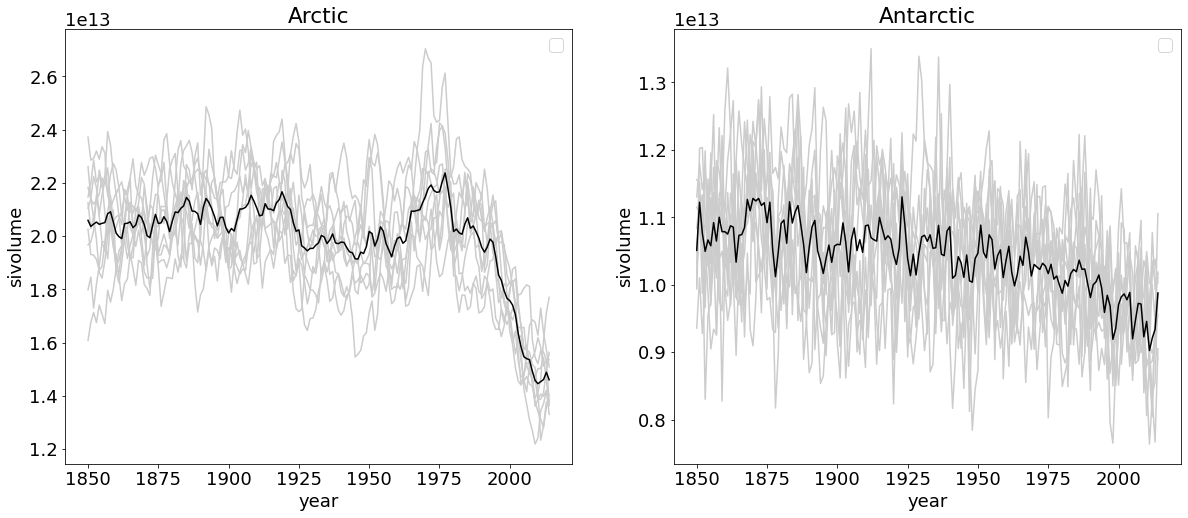

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sivolume_nh.groupby('time.year').mean('time').plot.line(x='year', color='0.8', ax=ax1)
sivolume_nh.groupby('time.year').mean(('time', 'ensmem')).plot.line(x='year', color='k', ax=ax1)
ax1.set_title('Arctic')
ax1.legend(())

sivolume_sh.groupby('time.year').mean('time').plot.line(x='year', color='0.8', ax=ax2)
sivolume_sh.groupby('time.year').mean(('time', 'ensmem')).plot.line(x='year', color='k', ax=ax2)
ax2.set_title('Antarctic')
ax2.legend(())

In [19]:
dout_nh = '/glade/work/apauling/volcano/sivolume/sivol_'+model+'_nh.nc'
dout_sh = '/glade/work/apauling/volcano/sivolume/sivol_'+model+'_sh.nc'

In [20]:
sivolume_nh.to_dataset().to_netcdf(dout_nh)
sivolume_sh.to_dataset().to_netcdf(dout_sh)

In [34]:
ddir = '/glade/scratch/apauling/cmip6/MIROC6/simass/'
dfiles = sorted(glob(ddir + '*195001-201412.nc'))


ds = xr.open_mfdataset(dfiles, combine='nested', concat_dim='ensmem')
ds

,Array,Chunk
Bytes,36.86 MB,737.28 kB
Shape,"(50, 256, 360)","(1, 256, 360)"
Count,205 Tasks,50 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,36.86 MB,737.28 kB
Shape,"(50, 256, 360)","(1, 256, 360)"
Count,205 Tasks,50 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [37]:
lat = ds.latitude[0, :, :]
lat

<xarray.DataArray 'latitude' (y: 256, x: 360)>
dask.array<getitem, shape=(256, 360), dtype=float64, chunksize=(256, 360), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y          (y) float64 -88.0 -85.75 -85.25 -84.75 ... 148.6 150.5 152.4
    latitude   (y, x) float64 dask.array<chunksize=(256, 360), meta=np.ndarray>
    longitude  (y, x) float64 dask.array<chunksize=(256, 360), meta=np.ndarray>
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    bounds:         vertices_latitude